---
title: "Conformal Prediction with Mapie"
date: "2023-01-17"
image: "image.png"
format:
  html:
    code-fold: true
    code-line-numbers: false
jupyter: python3
---

Quantifying the uncertainty of model predictions is essential when we want to evaluate a model and use it to inform our decisions. In this blog post, we'll take a quick look at one particular approach for this: conformal prediction. Compared to other methods like Bayesian modeling or quantile regression, conformal prediction has three advantages: 1) it has a probabilistic guarantee of covering the true outcome, 2) it doesn't assume a specific distribution of the data, and 3) it doesn't require a specific model.

## Conformal Prediction for Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, HistGradientBoostingRegressor
from mapie.classification import MapieClassifier
from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from mapie.metrics import classification_coverage_score, regression_coverage_score, regression_mean_width_score

rng = np.random.default_rng(2)

Let's say we have a classification problem with three classes and two features that looks like this:

In [2]:
def make_classification_problem(n_samples=1_000):
    centers = [(2, -2), (-2.5, -1), (0, 1)]
    covs = [np.eye(2), np.eye(2)*2, np.diag([5, 1])]
    X = np.vstack([
        rng.multivariate_normal(center, cov, n_samples)
        for center, cov in zip(centers, covs)
    ])
    y = np.hstack([np.full(n_samples, i) for i in range(3)])
    return X, y

X, y = make_classification_problem(n_samples=1_500)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

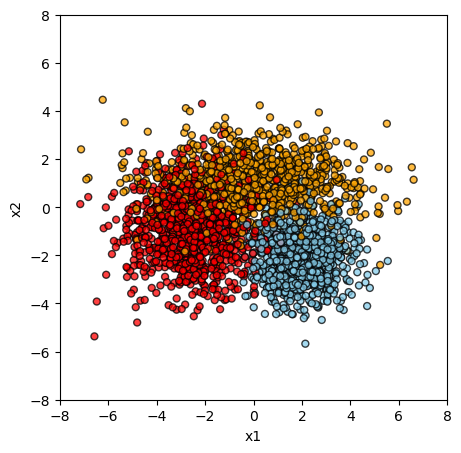

In [3]:
colormap = {0: "skyblue", 1: "red", 2: "orange"}
y_color = list(map(colormap.get, y_train))
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_train[:, 0], X_train[:, 1], color=y_color, alpha=0.75, marker="o", edgecolor="black", s=25)
ax.set(xlabel="x1", ylabel="x2", xlim=(-8, 8), ylim=(-8, 8));

We can easily fit a `RandomForestClassifier` (which is probably not the best model for this problem but nevermind) and produce output probabilities with the `predict_proba()` method. 

In [4]:
#| code-fold: show
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)
y_pred

array([[0.  , 0.16, 0.84],
       [0.04, 0.89, 0.07],
       [1.  , 0.  , 0.  ],
       ...,
       [1.  , 0.  , 0.  ],
       [0.  , 0.61, 0.39],
       [0.02, 0.98, 0.  ]])

These output "probabilities", however, shouldn't be interpreted as actual probabilities because they don't come with a probabilistic guarantee of covering the true outcome. Instead they should be treated as uncertainty scores that have to be calibrated. Let's see how conformal prediction comes to the rescue.

In conformal prediction, we first set aside some unseen data for calibration; this is usually called the calibration split (this is *not* equal to the validation data but an additional split). After training a model on the training data, we compute output "probabilities" for the examples in the calibration data and use them to compute a new score of uncertainty, the non-conformity scores:

```
non_conformity_score = 1 - score_for_true_class
```

For example, if the model predicts a score of $0.89$ for the correct class, the non-conformity score for this example will be $1 - 0.89 = 0.11$. That is, if the model is confident and correct, the corresponding score will be low; if the model is confident and wrong, the score will be high.

In [5]:
#| code-fold: show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
X_val, X_cal, y_val, y_cal = train_test_split(X_val, y_val, test_size=0.4)

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [6]:
#| code-fold: show
y_cal_pred = model.predict_proba(X_cal)
scores_true_class = y_cal_pred[np.arange(len(y_cal)), y_cal]
scores_true_class[:10]

array([0.7 , 0.77, 0.17, 1.  , 0.02, 0.83, 1.  , 0.98, 0.95, 1.  ])

In [7]:
#| code-fold: show
non_conformity_scores = 1 - scores_true_class

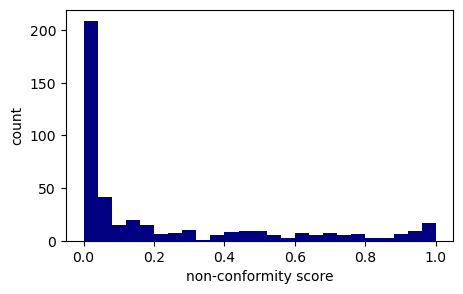

In [8]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(non_conformity_scores, bins=25, color="navy")
ax.set(xlabel="non-conformity score", ylabel="count");

We now pick a confidence level $\alpha$ (say $\alpha=0.05$) and find the threshold where $\alpha$% of the non-conformity scores are above (more uncertain) and $1-\alpha$% are below (more certain):

In [9]:
#| code-fold: show
alpha = 0.05 # ignoring the finite sample correction for simplicity
q_hat = np.quantile(non_conformity_scores, 1-alpha)
q_hat

0.9299999999999999

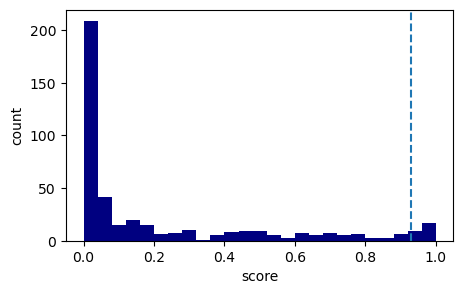

In [10]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(non_conformity_scores, bins=25, color="navy")
ax.set(xlabel="score", ylabel="count")
ax.axvline(q_hat, ls="--");

What is the meaning of `q_hat`? For non-conformity scores below `q_hat`, we know that, with probability $1-\alpha$, the prediction includes the correct class. That is, for prediction we would compute the non-conformity scores for all examples (that we want to predict), and select all class labels with a score below `q_hat`. This of course means that we can end up with prediction sets (i.e., predictions that include more than one class):

In [11]:
#| code-fold: show
preds = model.predict_proba(X_test)
preds

array([[0.98, 0.02, 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       ...,
       [0.  , 0.04, 0.96],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ]])

In [12]:
#| code-fold: show
preds_set = 1 - preds <= q_hat
preds_set

array([[ True, False, False],
       [ True, False, False],
       [False,  True, False],
       ...,
       [False, False,  True],
       [ True, False, False],
       [ True, False, False]])

Of course there is more to it (e.g., there are more ways to compute the conformity scores), but this is conformal prediction in a nutshell. Luckily, there's the [MAPIE library](https://github.com/scikit-learn-contrib/MAPIE) that is scikit-learn compatible, easy to use, and hides away many complexities. Learn more about the theory behind it [here](https://mapie.readthedocs.io/en/latest/theoretical_description_classification.html).

Let's see how we can use `mapie` in our example. Essentially, we wrap our model in the `MapieClassifier` class and `fit` it on the calibration data. We specify `cv="prefit"` since we have already fitted our model (to the training data) and `method="score"` since we want to use the conformity scores (1 minus the output score for the true class) to get the prediction sets.

In [13]:
#| code-fold: show
mapie = MapieClassifier(estimator=model, cv="prefit", method="score")
mapie.fit(X_cal, y_cal)

MapieClassifier(cv='prefit', estimator=RandomForestClassifier())

Like we did above, we can now visualize the scores. This time, we'll try different values for $\alpha$:

In [14]:
x_min = y_min = -8
x_max = y_max = 8
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(x_min, x_max, 0.1))
X_plot = np.stack([xx.ravel(), yy.ravel()], axis=1)

In [15]:
#| code-fold: show
alpha = [0.05, 0.1, 0.25]
# y_plot_preds are the predictions by the base estimator
# y_plot_ps are the prediction sets as estimated by MAPIE (here: for different alpha values)
y_plot_preds, y_plot_ps = mapie.predict(X_plot, alpha=alpha)

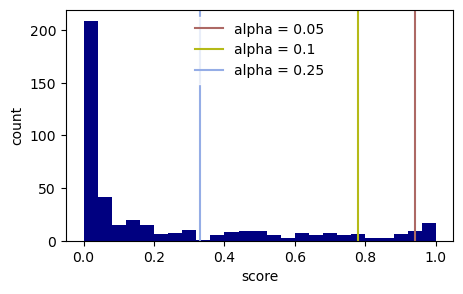

In [16]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(mapie.conformity_scores_, bins=25, color="navy")
quantiles = mapie.quantiles_
colors = {0: "#ad6965", 1: "#b5ba18", 2: "#95ade6"}
for i, quantile in enumerate(quantiles):
    ax.axvline(x=quantile, color=colors[i], label=f"alpha = {alpha[i]}")
ax.set(xlabel="score", ylabel="count")
ax.legend(edgecolor="white");

Now let's turn our attention to the prediction sets that were estimated by MAPIE using conformal prediction. The plot below shows the class labels predicted by the `RandomForestClassifier` (i.e., the class with the highest output probability) and the size of the corresponding prediction sets depending on the chosen $\alpha$ value. Unsurprisingly, the higher $\alpha$, the smaller the prediction sets. (Note that prediction sets can be empty when the model is too uncertain. E.g., see the white areas in the plot for $\alpha=0.25$.)

In [17]:
# slightly adapted from https://mapie.readthedocs.io/en/latest/examples_classification/4-tutorials/plot_main-tutorial-classification.html#sphx-glr-examples-classification-4-tutorials-plot-main-tutorial-classification-py
def plot_results(alphas, X, y_pred, y_ps):
    cm = plt.colormaps["Greys"]
    colors = {0: "skyblue", 1: "red", 2: "orange"}
    y_pred_col = list(map(colors.get, y_pred))
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(8, 8))
    axs = {0: ax1, 1: ax2, 2:  ax3, 3: ax4}
    axs[0].scatter(X[:, 0], X[:, 1], color=y_pred_col, marker='.', s=10, alpha=0.4)
    axs[0].set_title("Predicted labels")
    for i, alpha in enumerate(alphas):
        y_pi_sums = y_ps[:, :, i].sum(axis=1)
        num_labels = axs[i+1].scatter(X[:, 0], X[:, 1], c=y_pi_sums, marker='.', s=10, alpha=1, cmap=cm, vmin=0, vmax=3)
        plt.colorbar(num_labels, ax=axs[i+1])
        axs[i+1].set_title(f"Number of labels for alpha={alpha}")
    plt.show()

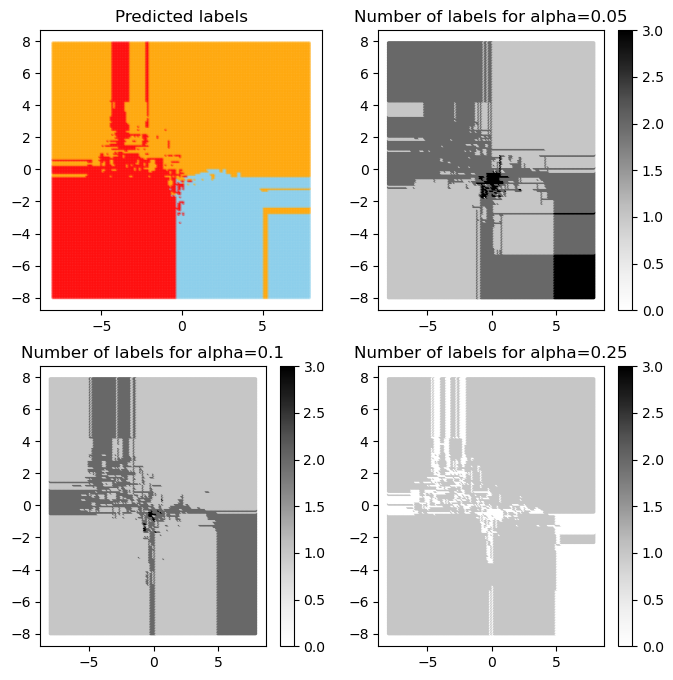

In [18]:
plot_results(alpha, X_plot, y_plot_preds, y_plot_ps)

Finally, we can compute the effective coverage score for different $\alpha$ values. The effective coverage is the fraction of true labels that lie within the prediction sets:

In [19]:
for alpha in [0.05, 0.1, 0.25]:
    _, y_test_ps = mapie.predict(X_test, alpha=alpha)
    coverage_score = classification_coverage_score(y_test, y_test_ps[:, :, 0])
    print(f"coverage score for alpha={alpha}:\t {coverage_score:.3f}")

coverage score for alpha=0.05:	 0.969
coverage score for alpha=0.1:	 0.933
coverage score for alpha=0.25:	 0.796


Note: If we had two models with the same coverage of the true class labels, we would pick the one with fewer wrong labels in the prediction sets.

## Conformal Prediction For Regression

Let's move on to regression problems. The intuition stays the same, but (naturally) the computation of the non-conformity scores changes. We now work with the absolute residual values:

```
non_conformity_score = abs(true_value - predicted_value)
```

To conformalize the scores, we again find the threshold `q_hat` so that $\alpha$% of the predictions have a score above and $1-\alpha$ below. The prediction interval for a new example then includes all predictions that produce a score below `q_hat`.

Let's build a model for the [concrete strength prediction](https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength) dataset:

In [20]:
base_path = "./ConcreteStrengthData.csv"

In [21]:
df = pd.read_csv(base_path)
target = "Strength"
features = [col for col in df.columns if col != target]
df.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [22]:
X, y = df[features].to_numpy(), df[target].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.2)

We'll now use sklearn's `GradientBoostingRegressor` model as our base estimator (just to show that the model doesn't matter for conformal prediction), the rest essentially stays the same.

In [23]:
#| code-fold: show
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
mapie = MapieRegressor(estimator=model, cv="prefit")
mapie.fit(X_cal, y_cal)
y_pred, y_pis = mapie.predict(X_test, alpha=0.05)

It's easy to put the results in a dataframe:

In [24]:
pred_df = pd.DataFrame({"y_test": y_test})
pred_df["y_pred"] = y_pred
pred_df["y_pred_lower"] = y_pis.reshape(-1, 2)[:, 0]
pred_df["y_pred_upper"] = y_pis.reshape(-1, 2)[:, 1]
pred_df

,y_test,y_pred,y_pred_lower,y_pred_upper
0,16.26,18.467521,7.362651,29.572392
1,24.28,23.462614,12.357743,34.567485
2,33.40,34.357187,23.252316,45.462058
3,18.03,24.493210,13.388339,35.598081
4,31.27,31.556663,20.451792,42.661534
...,...,...,...,...
98,44.86,34.840504,23.735633,45.945375
99,12.05,9.560611,-1.544260,20.665482
100,29.22,27.739812,16.634941,38.844683
101,29.07,32.684207,21.579336,43.789078


In [25]:
coverage_score = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
print(f"Coverage score: {coverage_score:.3f}")
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])
print(f"Interval width: {width:.3f}")

Coverage score: 0.971
Interval width: 22.210


As we can see below, the prediction interval width is fixed. 

In [26]:
# adapted from: https://mapie.readthedocs.io/en/latest/examples_regression/4-tutorials/plot_cqr_tutorial.html

def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot_prediction_intervals(
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """

    error = y_pred_sorted-lower_bound

    warning1 = y_test_sorted > y_pred_sorted+error
    warning2 = y_test_sorted < y_pred_sorted-error
    warnings = warning1 + warning2
    ax.errorbar(
        y_test_sorted[~warnings],
        y_pred_sorted[~warnings],
        yerr=error[~warnings],
        capsize=3, marker="o", markersize=4, 
        elinewidth=1, linewidth=0, alpha=0.7,
        label="Inside prediction interval"
        )
    ax.errorbar(
        y_test_sorted[warnings],
        y_pred_sorted[warnings],
        yerr=error[warnings],
        capsize=3, marker="o", markersize=4, 
        elinewidth=1, linewidth=0, alpha=0.7,
        color="red",
        label="Outside prediction interval"
        )
    ax.set_xlabel("True Strength")
    ax.set_ylabel("Predicted Strength")
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")

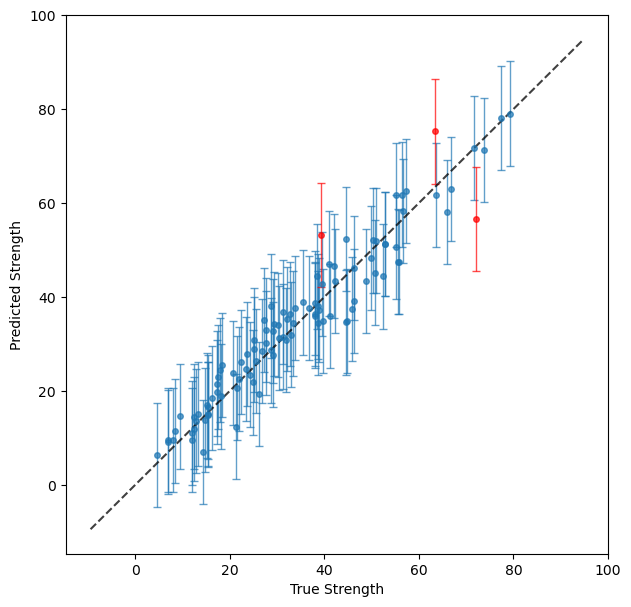

In [27]:
fig, ax = plt.subplots(figsize=(7, 7))
y_test_sorted, y_pred_sorted, lower_bound, upper_bound = sort_y_values(y_test, y_pred, y_pis)
plot_prediction_intervals(ax, y_test_sorted, y_pred_sorted, lower_bound, upper_bound)

## Conformalized Quantile Regression

Interestingly, there is another option for conformal prediction in regression problems: conformalized quantile regression. That is, we start with a quantile regression model (e.g., a `HistGradientBoostingRegressor` with `loss="quantile"` or a LightGBM model with `objective="quantile"`) that already outputs lower and upper quantiles, and use conformal prediction to obtain probabilistic guarantees. MAPIE offers a `MapieQuantileRegressor` class dedicated to this purpose.

The computation of the non-conformity score changes again:

```
non_conformity_score = max(q_low - y, y - q_up)
```

We now get positive scores when the true value (`y`) lies outside of the interval predicted by the quantile regression model, and negative scores if it lies inside. The threshold `q_hat` can now be interpreted as an adjustment term for the width of the prediction intervals. That is, if the threshold value is positive, the prediction intervals get expanded (by that value) on both ends. If the threshold value is negative, the prediction intervals become more narrow. 

Since quantile regression is inherently adaptive, this will result in adaptive prediction intervals (even though the procedure for calibration is not adaptive). 

Let's work with the concrete strength dataset again. (Note: Since the focus of this blog post is on conformal prediction, we don't spend time with feature engineering and hyperparameter optimization.)

In [38]:
#| code-fold: show
model = HistGradientBoostingRegressor(loss="quantile", quantile=0.05, learning_rate=0.09)
model.fit(X_train, y_train)
mapie = MapieQuantileRegressor(estimator=model, alpha=0.05)
mapie.fit(X_train, y_train, X_calib=X_cal, y_calib=y_cal)
y_pred, y_pis = mapie.predict(X_test)

/Users/jm/mambaforge/envs/scibase/lib/python3.10/site-packages/mapie/utils.py:484: UserWarning: WARNING: The predictions of the quantile regression have issues.
The upper quantile predictions are lower
than the lower quantile predictions
at some points.
  warnings.warn(
/Users/jm/mambaforge/envs/scibase/lib/python3.10/site-packages/mapie/utils.py:502: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(


In [39]:
coverage_score = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
print(f"Coverage score: {coverage_score:.3f}")
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])
print(f"Interval width: {width:.3f}")

Coverage score: 0.990
Interval width: 26.275


Let's plot the prediction intervals again. As promised, they are now adaptive:

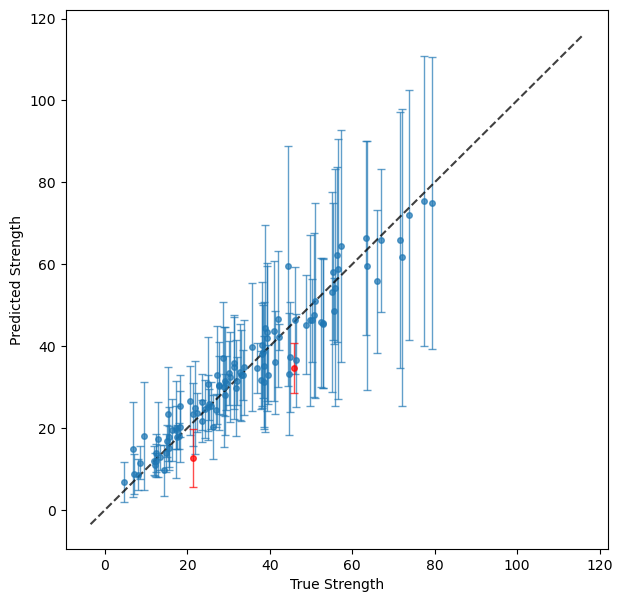

In [40]:
fig, ax = plt.subplots(figsize=(7, 7))
y_test_sorted, y_pred_sorted, lower_bound, upper_bound = sort_y_values(y_test, y_pred, y_pis)
plot_prediction_intervals(ax, y_test_sorted, y_pred_sorted, lower_bound, upper_bound)

That's a wrap! Conformal prediction doesn't stop at simple tabular classification and regression tasks, however. Since the procedure doesn't require specific models we can use conformal prediction even for tasks like image segmentation. Have a look at this [repo](https://github.com/valeman/awesome-conformal-prediction) for more resources.